In [3]:
import numpy as np

x = np.linspace(-10, 10, 100)
spacing = 2
sigma_values = np.linspace(1, spacing, 10)
x_range = np.linspace(-10, 10, 100)

In [4]:
from scipy.linalg import lstsq
from scipy.optimize import curve_fit
from scipy.optimize import lsq_linear
from scipy.optimize import nnls

In [5]:
def gaussian(x, sigma, center=0):
    gauss_eval = np.exp(-0.5 * ((x - center) / sigma)**2) / (sigma * np.sqrt(2 * np.pi))
    return gauss_eval

In [6]:
# curve fit
def find_coeffs_curve_fit():

    actual_gaussians = gaussian(x_range, sigma_values[:,np.newaxis])

    def gaussian_mix(xvals, weight):
        # Return a linear combination of two Gaussians with weights
        return (weight * gaussian(xvals, sigma=1)
                + (1-weight) * gaussian(xvals, sigma=spacing))

    lower_mix = np.zeros(len(sigma_values))

    for i in range(len(sigma_values)):
        actual_gaussian = actual_gaussians[i]
        mixl, _ = curve_fit(gaussian_mix, x_range,
                            ydata=actual_gaussian, p0=[0.5], bounds=(0, 1))
        lower_mix[i] = mixl[0]

    coeffs = np.polyfit(sigma_values, lower_mix, 3)
    return coeffs

coeffs = find_coeffs_curve_fit()

In [7]:
%timeit find_coeffs_curve_fit()

19.8 ms ± 440 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
# lstsq
def find_coeffs_lstsq():

    actual_gaussians = gaussian(x_range, sigma_values[:,np.newaxis])

    lower_mix = np.zeros(len(sigma_values))

    ref_gaussians = actual_gaussians[[0, -1]].T

    for i in range(len(sigma_values)):
        actual_gaussian = actual_gaussians[i]
        res = lstsq(ref_gaussians, actual_gaussian)
        lower_mix[i] = res[0][0]

    coeffs = np.polyfit(sigma_values, lower_mix, 3)
    return coeffs

In [9]:
%timeit find_coeffs_lstsq()

472 µs ± 4.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


To avoid solutions where weights are negative, we can use lsq_linear which supports bounded problems. This provides a faster solution that curve_fit as it is contstrained to linear problems, but is still slower than using lstsq.

In [14]:
# lsq_linear
def find_coeffs_lsq_linear():

    actual_gaussians = gaussian(x_range, sigma_values[:,np.newaxis])

    lower_mix = np.zeros(len(sigma_values))

    ref_gaussians = actual_gaussians[[0, -1]].T

    for i in range(len(sigma_values)):
        actual_gaussian = actual_gaussians[i]
        res = lsq_linear(ref_gaussians, actual_gaussian, bounds=(0,1))
        lower_mix[i] = res.x[0]

    coeffs = np.polyfit(sigma_values, lower_mix, 3)
    return coeffs

In [15]:
%timeit find_coeffs_lsq_linear()

5.41 ms ± 95.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Finally, we can use nnls which is a non-negative least solver which removes the issue of possible negative weights. This method is also the fastest of the solvers tested and therefore the most appropriate to use.

In [16]:
# nnls
def find_coeffs_nnls():

    actual_gaussians = gaussian(x_range, sigma_values[:,np.newaxis])

    lower_mix = np.zeros(len(sigma_values))

    ref_gaussians = actual_gaussians[[0, -1]].T

    for i in range(len(sigma_values)):
        actual_gaussian = actual_gaussians[i]
        res = nnls(ref_gaussians, actual_gaussian)
        lower_mix[i] = res[0][0]

    coeffs = np.polyfit(sigma_values, lower_mix, 3)
    return coeffs

In [17]:
%timeit find_coeffs_nnls()

179 µs ± 2.92 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


It is also useful to understand how the solutions produced from the solvers differ. In the below plot it can be seen that the three linear lesat squares solvers give visually identical solutions. There is a difference in the coefficients produced by curve fit compared to the other solvers, but the bottom plot shows that all 4 solvers produce very similar approximated gaussians. In fact, the linear solvers have a smaller magnitude of error at the peaks of the gaussians.

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

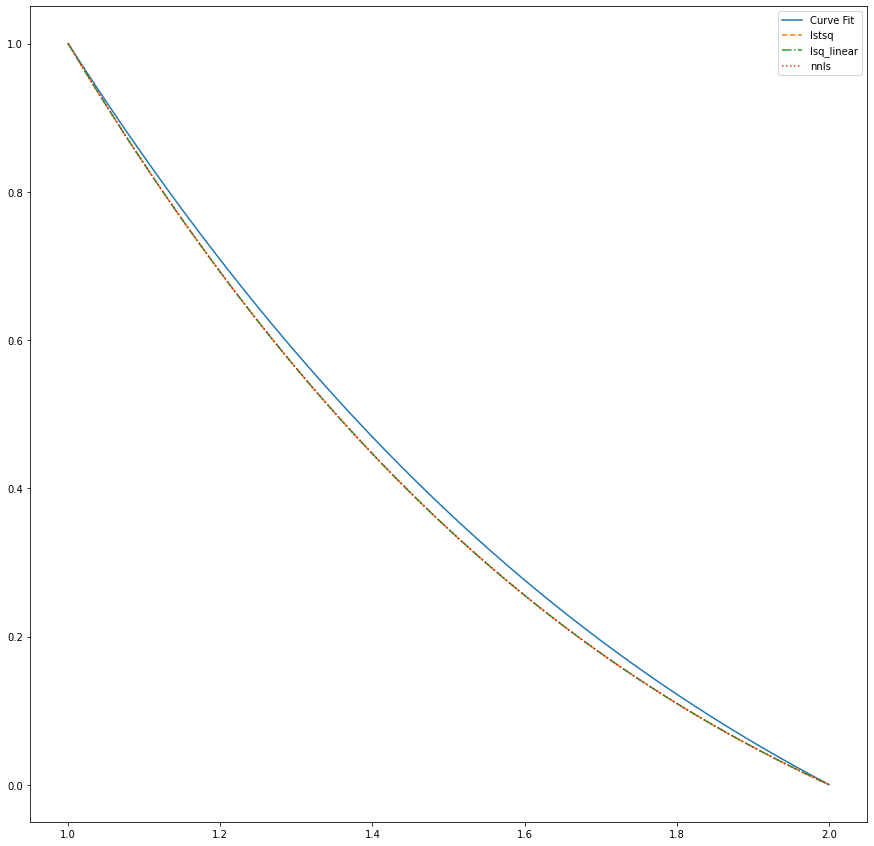

In [29]:
fig, ax = plt.subplots()
sigma_samples_fine = np.linspace(1, spacing, 1000)
plt.plot(sigma_samples_fine,
         np.polyval(find_coeffs_curve_fit(), sigma_samples_fine),
         label='Curve Fit')
plt.plot(sigma_samples_fine,
         np.polyval(find_coeffs_lstsq(), sigma_samples_fine), '--',
         label='lstsq')
plt.plot(sigma_samples_fine,
         np.polyval(find_coeffs_lsq_linear(), sigma_samples_fine), '-.',
         label='lsq_linear')
plt.plot(sigma_samples_fine,
         np.polyval(find_coeffs_nnls(), sigma_samples_fine), ':',
         label='nnls')
plt.legend()

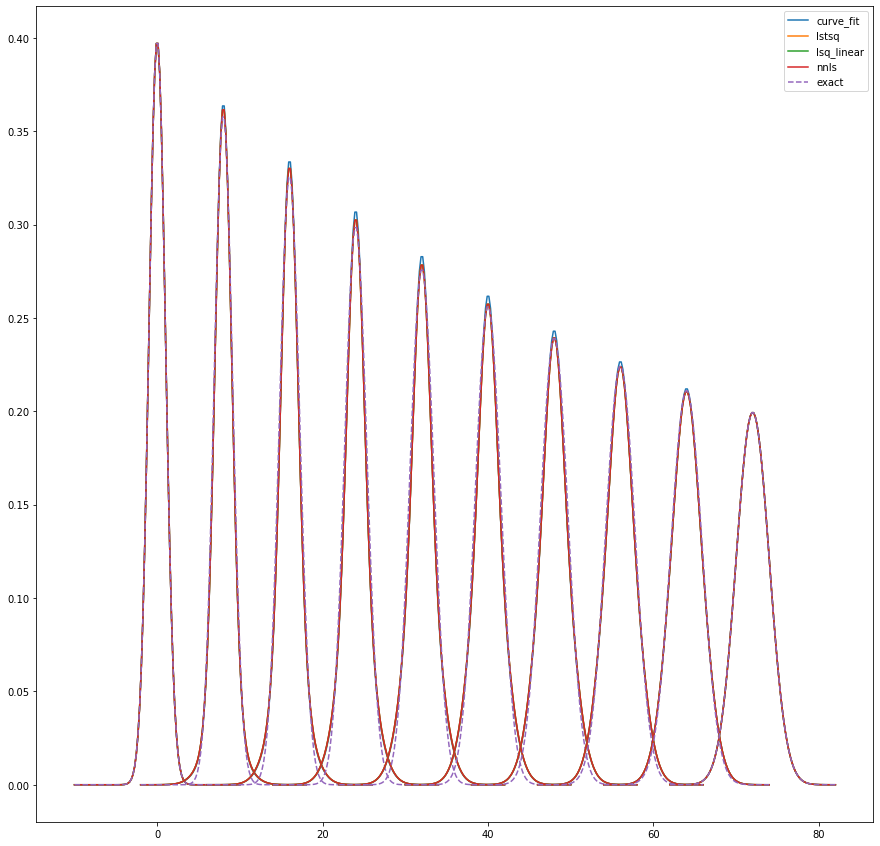

In [34]:
fig, ax = plt.subplots()
curve_fit_poly = find_coeffs_curve_fit()
lstsq_poly = find_coeffs_lstsq()
lsq_linear_poly = find_coeffs_lsq_linear()
nnls_poly = find_coeffs_nnls()

ref_gaussian0 = gaussian(x, sigma=1)
ref_gaussian1 = gaussian(x, sigma=spacing)

def legend_without_duplicate_labels(ax):
            handles, labels = ax.get_legend_handles_labels()
            unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
            ax.legend(*zip(*unique))

for i, sigma_sample in enumerate(sigma_values):
    exact = gaussian(x, sigma_sample)
    cf_mix = np.polyval(curve_fit_poly, sigma_sample)
    cf_res = ref_gaussian0 * cf_mix + ref_gaussian1 * (1 - cf_mix)
    lsq_mix = np.polyval(lstsq_poly, sigma_sample)
    lsq_res = ref_gaussian0 * lsq_mix + ref_gaussian1 * (1 - lsq_mix)
    lsql_mix = np.polyval(lsq_linear_poly, sigma_sample)
    lsql_res = ref_gaussian0 * lsql_mix + ref_gaussian1 * (1 - lsql_mix)
    nnls_mix = np.polyval(nnls_poly, sigma_sample)
    nnls_res = ref_gaussian0 * nnls_mix + ref_gaussian1 * (1 - nnls_mix)

    plt.plot(x + 8*i, cf_res, 'C0', label='curve_fit')
    plt.plot(x + 8*i, lsq_res, 'C1', label='lstsq')
    plt.plot(x + 8*i, lsql_res, 'C2' ,label='lsq_linear')
    plt.plot(x + 8*i, nnls_res, 'C3' ,label='nnls')
    plt.plot(x + 8*i, exact, 'C4', linestyle='--', label='exact')

    legend_without_duplicate_labels(ax)